In [456]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd



In [457]:
# Load audio file to listen
filename = "/Users/Ritvik/Desktop/Retromatch/retromatch/Hyperfine_1.m4a"
# Load audio file as waveform
y, sr = librosa.load(filename, sr=None)
#y = y[6000000:12500000]  # trim to beep segment
sample_rate=sr
print(f'y shape= {y.shape}')
print(f'y_max = {np.max(y)}')
print(f'sample_rate = {sample_rate}')

import soundfile as sf


# Check your working waveform and sr
print(f"Waveform shape: {y.shape}")
print(f"Declared sample rate: {sample_rate}")



y shape= (19204032,)
y_max = 0.94500732421875
sample_rate = 32000
Waveform shape: (19204032,)
Declared sample rate: 32000


Detected scanner block: 271.57s – 271.82s
Detected 1 scan cycles


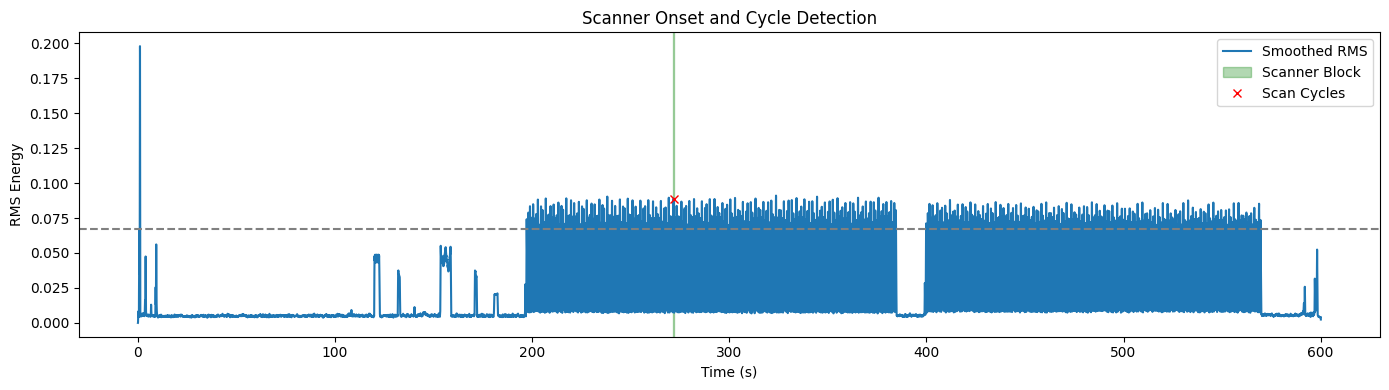

In [458]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load audio
y, sr = librosa.load(filename, sr=None)

# Compute RMS
hop_length = 512
frame_length = 2048
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length).flatten()
times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)

# Smooth RMS
rms_smooth = np.convolve(rms, np.ones(10)/10, mode='same')

# Threshold
threshold = np.mean(rms_smooth) + 1.5 * np.std(rms_smooth)

# Find candidate regions
high_energy = rms_smooth > threshold
edges = np.diff(high_energy.astype(int))
starts = np.where(edges == 1)[0]
ends = np.where(edges == -1)[0]
if ends[0] < starts[0]:
    ends = ends[1:]
if len(ends) > len(starts):
    ends = ends[:len(starts)]

# Pick longest sustained block
durations = ends - starts
best_idx = np.argmax(durations)
start_idx = starts[best_idx]
end_idx = ends[best_idx]
print(f"Detected scanner block: {times[start_idx]:.2f}s – {times[end_idx]:.2f}s")

# Count scan cycles within block
rms_block = rms_smooth[start_idx:end_idx]
times_block = times[start_idx:end_idx]
peaks, _ = find_peaks(rms_block, height=threshold, distance=int(sr * 4 / hop_length))  # ~4s cycle
print(f"Detected {len(peaks)} scan cycles")

# Plot
plt.figure(figsize=(14,4))
plt.plot(times, rms_smooth, label='Smoothed RMS')
plt.axhline(threshold, color='gray', linestyle='--')
plt.axvspan(times[start_idx], times[end_idx], color='green', alpha=0.3, label='Scanner Block')
plt.plot(times_block[peaks], rms_block[peaks], 'x', color='red', label='Scan Cycles')
plt.xlabel("Time (s)")
plt.ylabel("RMS Energy")
plt.legend()
plt.title("Scanner Onset and Cycle Detection")
plt.tight_layout()
plt.show()


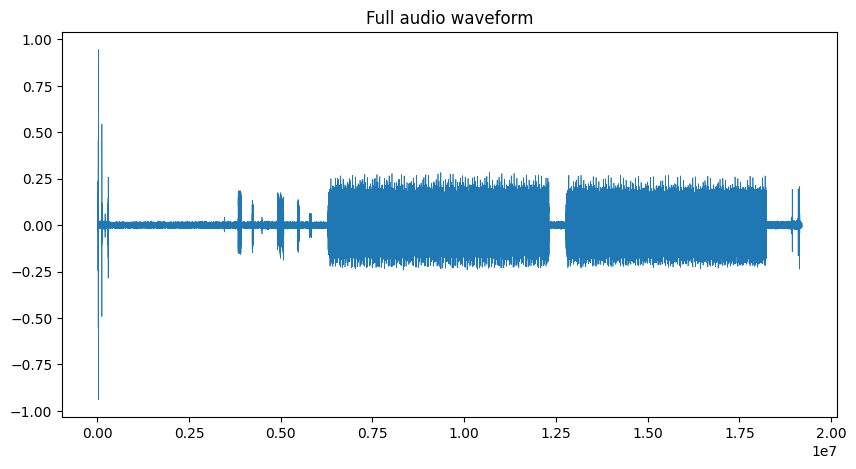

In [459]:
pd.Series(y).plot(figsize= (10,5),
                  title='Full audio waveform',
                  lw=0.5)

plt.show()



In [461]:
#segment=y[2500000:2600000]
segment=y

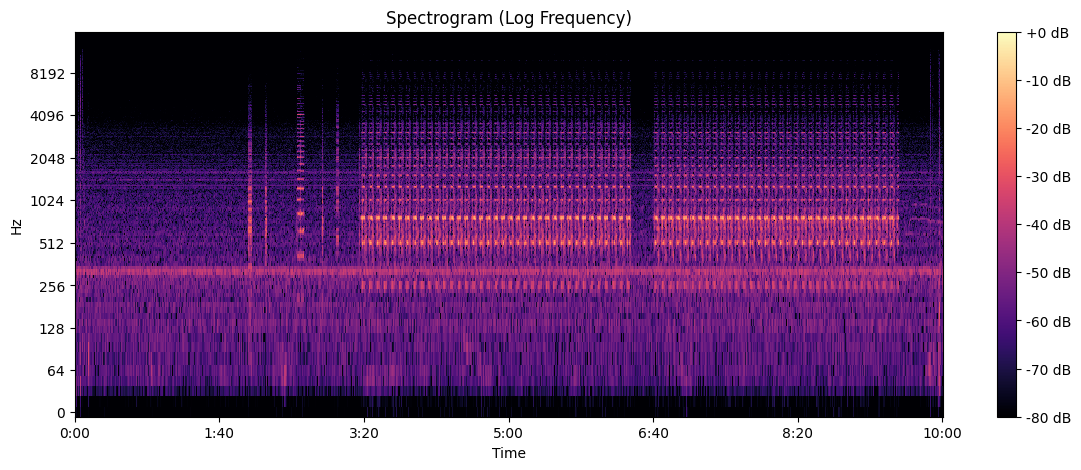

In [462]:
D = librosa.stft(segment, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sample_rate, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Log Frequency)')
plt.show()

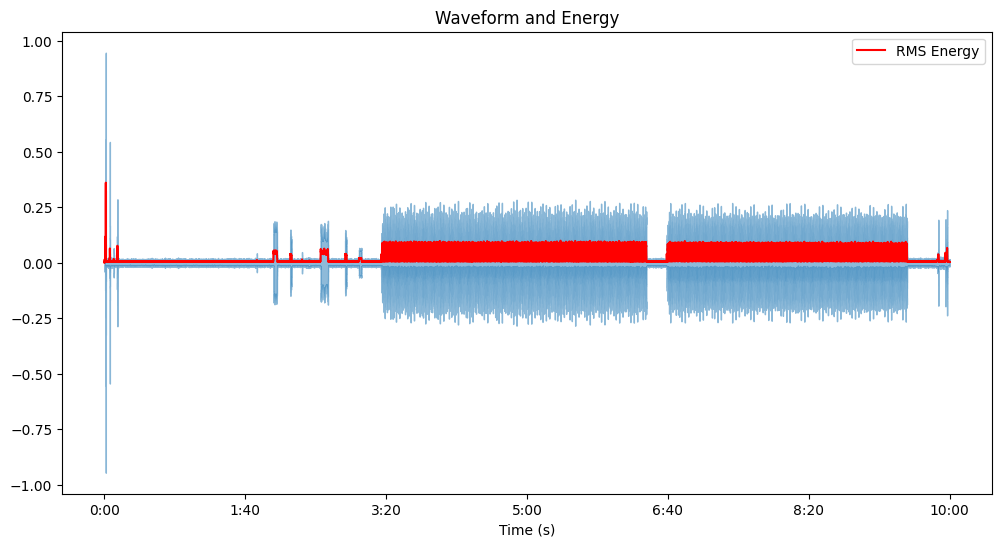

In [463]:
# Compute energy (RMS)
hop_length = 512
rms = librosa.feature.rms(y=segment, hop_length=hop_length)[0]
frames = range(len(rms)) 
times = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

# Plot both waveform and energy
plt.figure(figsize=(12, 6))
librosa.display.waveshow(segment, sr=sample_rate, alpha=0.5)
plt.plot(times, rms, color='r', label='RMS Energy')
plt.title('Waveform and Energy')
plt.xlabel('Time (s)')
#plt.xticks(np.arange(0, 601, 30))
plt.legend()
plt.show()

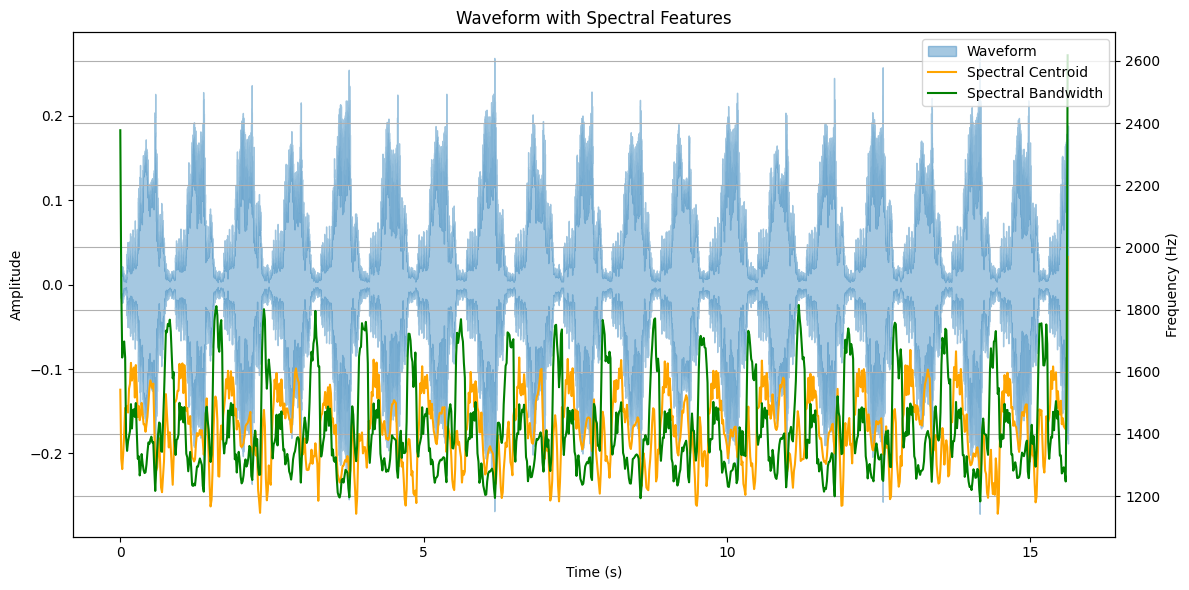

In [431]:
# Feature extraction
spect_centroid = librosa.feature.spectral_centroid(y=segment, sr=sample_rate, n_fft=2048, hop_length=hop_length)[0]
spect_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sample_rate, n_fft=2048, hop_length=hop_length)[0]

# Time axis
frames = range(len(spect_centroid))
times = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis: waveform
librosa.display.waveshow(segment, sr=sample_rate, alpha=0.4, ax=ax1, label='Waveform')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time (s)')

# Right Y-axis: frequency features
ax2 = ax1.twinx()
ax2.plot(times, spect_centroid, label='Spectral Centroid', color='orange')
ax2.plot(times, spect_bandwidth, label='Spectral Bandwidth', color='green')
ax2.set_ylabel('Frequency (Hz)')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Waveform with Spectral Features')
plt.grid(True)
plt.tight_layout()
plt.show()



X shape= (977, 3)


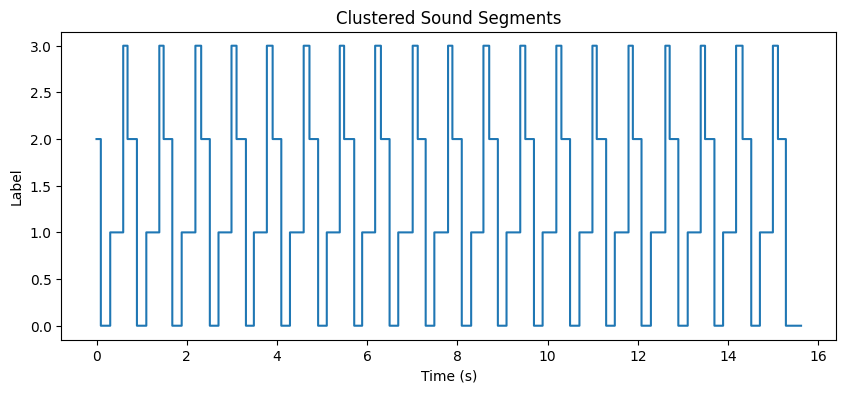

In [446]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.ndimage import gaussian_filter1d
# Try zero-crossing rate or MFCCs



rms_smoothed = gaussian_filter1d(rms, sigma=4)  # Smooth RMS 
spect_centroid_smoothed = gaussian_filter1d(spect_centroid, sigma=4)  # Smooth spectral centroid
spect_bandwidth_smoothed = gaussian_filter1d(spect_bandwidth, sigma=4)  # Smooth spectral bandwidth


# Stack features
X = np.stack([rms_smoothed, spect_centroid_smoothed, spect_bandwidth_smoothed], axis=1)  # shape: [frames, features]
print(f'X shape= {X.shape}')
X_scaled = StandardScaler().fit_transform(X)

# Run clustering
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_


# Visualize
plt.figure(figsize=(10, 4))
plt.plot(times, labels, label='Cluster Label', drawstyle='steps')
plt.xlabel("Time (s)")
plt.ylabel("Label")
plt.title("Clustered Sound Segments")
plt.show()


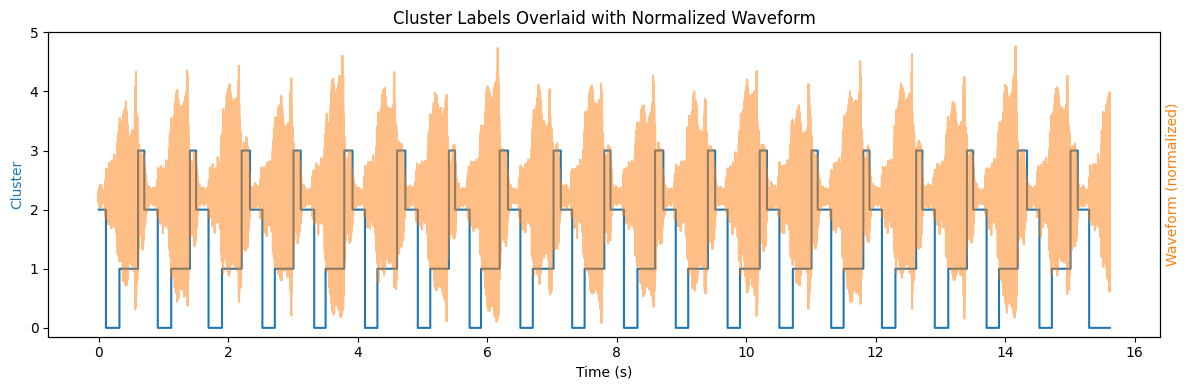

In [447]:
# Normalize waveform (segment) to match cluster label scale
segment_norm = segment / np.max(np.abs(segment))  # Normalize to [-1, 1]
segment_scaled = segment_norm * 1.5 + 1.5  # Shift to [0, 3] for better visibility above labels 0–2

# Convert waveform to same time axis as clustering
wave_times = np.linspace(times[0], times[-1], len(segment_scaled))

# Plot
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot cluster labels
ax1.step(times[:len(labels)], labels, where='post', label='Cluster Label', color='tab:blue')
ax1.set_ylabel('Cluster', color='tab:blue')
ax1.set_xlabel('Time (s)')
ax1.set_yticks([0, 1, 2, 3, 4, 5])  # Set y-ticks to match cluster labels
ax1.set_title('Cluster Labels Overlaid with Normalized Waveform')

# Twin axis for waveform
ax2 = ax1.twinx()
ax2.plot(wave_times, segment_scaled, label='Waveform (scaled)', color='tab:orange', alpha=0.5)
ax2.set_ylabel('Waveform (normalized)', color='tab:orange')
ax2.set_yticks([]) 

plt.tight_layout()
plt.show()

In [434]:
segments = []
start_idx = 0
for i in range(1, len(labels)):
    if labels[i] != labels[i-1]:
        segments.append({
            'start_time': times[start_idx],
            'end_time': times[i],
            'duration': times[i] - times[start_idx],
            'label': int(labels[i-1])
        })
        start_idx = i

df_segments = pd.DataFrame(segments)

# Check your working waveform and sr
print(f"Waveform shape: {y.shape}")
print(f"Declared sample rate: {sample_rate}")


Waveform shape: (6500000,)
Declared sample rate: 32000


In [436]:
def compute_rms_energy(segment, sr, start_time, end_time):
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    sub_segment = segment[start_sample:end_sample]
    rms = librosa.feature.rms(y=sub_segment)[0]
    return np.mean(rms)




In [437]:
df_segments["rms_energy"] = df_segments.apply(
    lambda row: compute_rms_energy(segment, sample_rate, row["start_time"], row["end_time"]),
    axis=1
)

# Check your working waveform and sr
print(f"Waveform shape: {y.shape}")
print(f"Declared sample rate: {sample_rate}")

Waveform shape: (6500000,)
Declared sample rate: 32000


In [438]:
new_labels = []

for i in range(0, len(df_segments), 4):
    group = df_segments.iloc[i:i+4]
    if len(group) < 4:
        continue  # skip incomplete cycles at the end

    # Find index of min RMS energy (inactive)
    min_idx = group["rms_energy"].idxmin()
    group_indices = group.index.tolist()
    inactive_pos = group_indices.index(min_idx)

    # Assign labels based on relative order
    label_order = ["inactive", "pre", "scan", "post"]
    for offset, name in enumerate(label_order):
        if inactive_pos + offset < 4:
            idx = group_indices[inactive_pos + offset]
            new_labels.append((idx, name))


# Create new label column
df_segments["event_label"] = None
for idx, name in new_labels:
    df_segments.at[idx, "event_label"] = name

# Check your working waveform and sr
print(f"Waveform shape: {y.shape}")
print(f"Declared sample rate: {sample_rate}")


Waveform shape: (6500000,)
Declared sample rate: 32000


In [439]:
# inactive column =
inactive_segments = df_segments[df_segments['event_label'] == 'inactive']

# Calculate time difference between consecutive inactives
inactive_starts = inactive_segments['start_time'].values
inactive_durations = np.diff(inactive_starts)

# Create dataframe
df_inactive_cycles = pd.DataFrame({
    'start_time': inactive_starts[:-1],
    'next_start_time': inactive_starts[1:],
    'cycle_duration': inactive_durations
})

print(df_inactive_cycles)

# Check your working waveform and sr
print(f"Waveform shape: {y.shape}")
print(f"Declared sample rate: {sample_rate}")


    start_time  next_start_time  cycle_duration
0        0.000            0.704           0.704
1        0.704            1.504           0.800
2        1.504            2.336           0.832
3        2.336            3.120           0.784
4        3.120            3.920           0.800
5        3.920            4.736           0.816
6        4.736            5.504           0.768
7        5.504            6.320           0.816
8        6.320            7.136           0.816
9        7.136            7.904           0.768
10       7.904            8.720           0.816
11       8.720            9.520           0.800
12       9.520           10.320           0.800
13      10.320           11.104           0.784
14      11.104           11.904           0.800
15      11.904           12.720           0.816
16      12.720           13.504           0.784
17      13.504           14.336           0.832
Waveform shape: (6500000,)
Declared sample rate: 32000


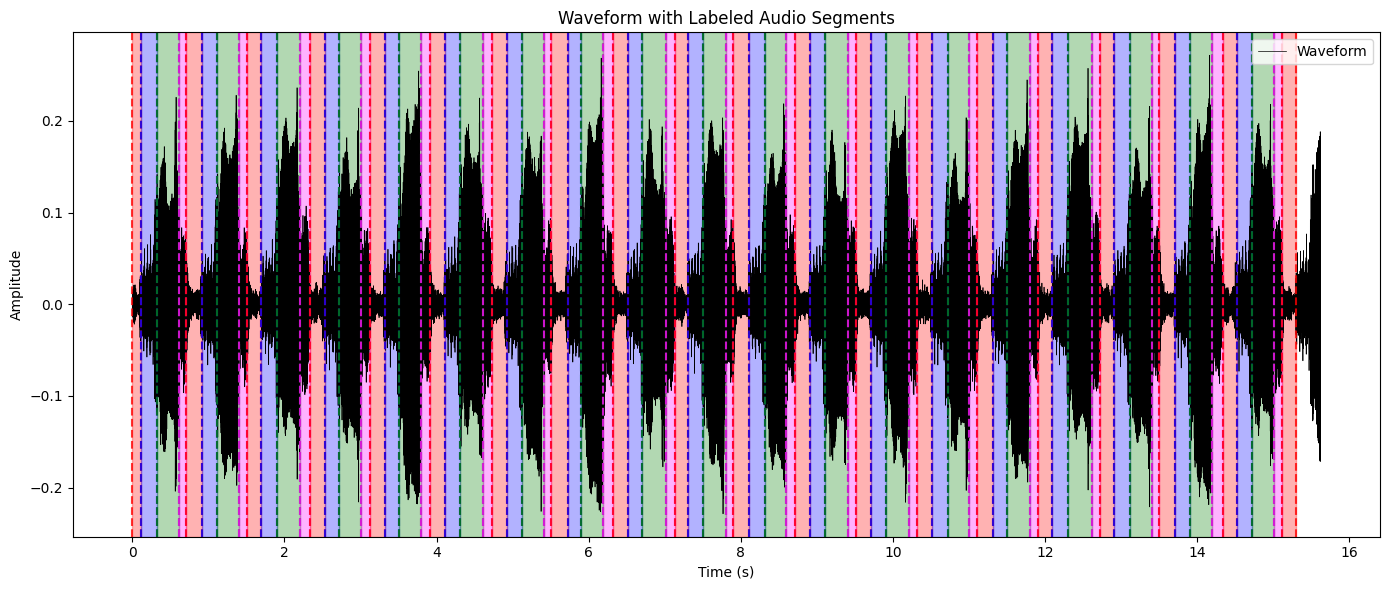

In [440]:
# Time axis for the waveform
waveform_times = np.linspace(0, len(segment)/sample_rate, num=len(segment))

plt.figure(figsize=(14, 6))
plt.plot(waveform_times, segment, linewidth=0.5, label='Waveform', color='black')

# Define colors for each label
label_colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'magenta', 
}

# Add shaded regions and markers for each labeled segment
for _, row in df_segments.iterrows():
    label = row['label']
    color = label_colors.get(label, 'gray')
    plt.axvspan(row['start_time'], row['end_time'], color=color, alpha=0.3)
    
    # Start/end markers
    plt.axvline(row['start_time'], color=color, linestyle='--', alpha=0.8)
    plt.axvline(row['end_time'], color=color, linestyle='--', alpha=0.8)

plt.title("Waveform with Labeled Audio Segments")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

Shape of S_Db= (1025, 508)


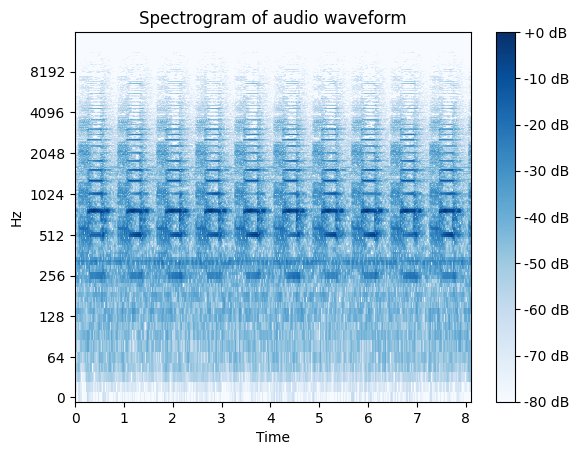

In [213]:
D=librosa.stft(y[2040000:2300000])
S_Db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
print(f'Shape of S_Db= {S_Db.shape}')
librosa.display.specshow(S_Db, sr=sr, x_axis='time', y_axis='log', cmap='Blues')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of audio waveform')
plt.show()

Generated fingerprint: 4733514384044589300


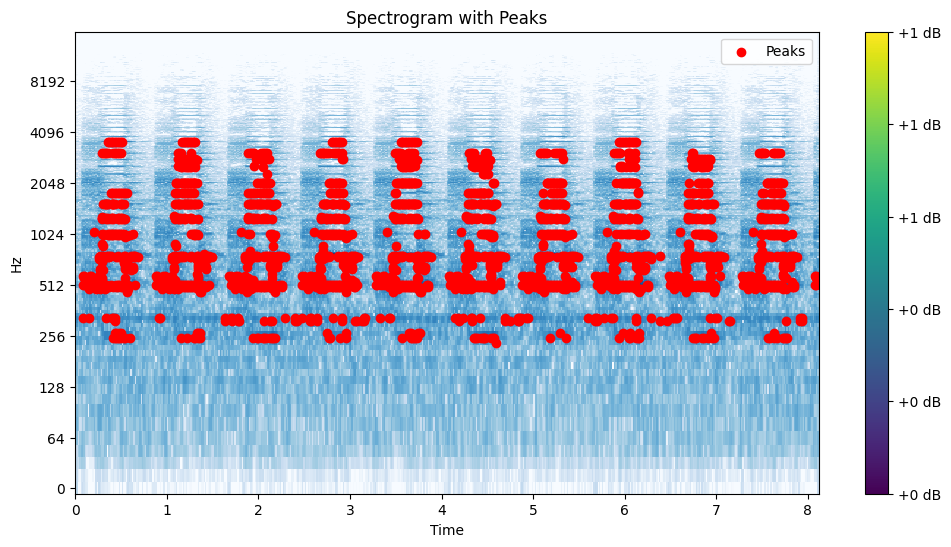

In [212]:
from scipy.ndimage import maximum_filter

# Identify peaks in the spectrogram
def extract_peaks(S_db, threshold=-25):
    peaks = maximum_filter(S_db, size=2) == S_db
    rows, cols = np.where(peaks)
    peaks_db = [(col, row) for col, row in zip(cols, rows) if S_db[row, col] > threshold]
    return peaks_db

peaks = extract_peaks(S_Db)


# Generate a fingerprint by hashing peaks
fingerprint = hash(tuple(peaks))
print(f"Generated fingerprint: {fingerprint}")

# Plot spectrogram with identified peaks
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_Db, sr=sr, x_axis='time', y_axis='log', cmap='Blues')
times = librosa.frames_to_time([p[0] for p in peaks], sr=sr)
freqs = librosa.fft_frequencies(sr=sr)[[p[1] for p in peaks]]
plt.scatter(times, freqs, marker='o', color='r', label='Peaks')
plt.colorbar(format="%+2.0f dB")
plt.title('Spectrogram with Peaks')
plt.legend()
plt.show()

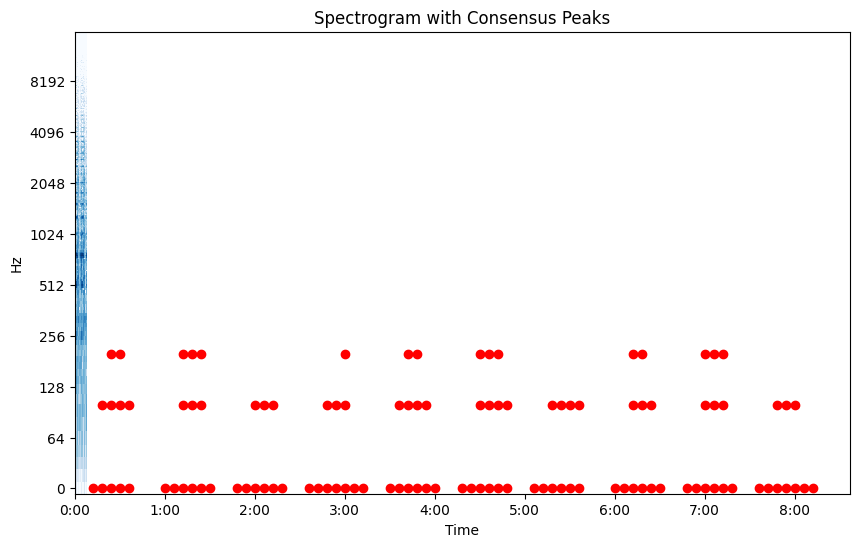

In [209]:
tolerance_freq = 100  # bins
tolerance_time = 6  # frames
rounded_peaks = [(round(f / tolerance_freq), round(t / tolerance_time)) for t, f in peaks]

from collections import Counter
counts = Counter(rounded_peaks)
threshold = 9  # appears in at least 9/10 cycles
common_peaks = [key for key, count in counts.items() if count >= threshold]
real_peaks = [(t * tolerance_time, f * tolerance_freq) for f, t in common_peaks]

plt.figure(figsize=(10, 6))
librosa.display.specshow(S_Db, sr=sr, x_axis='time', y_axis='log', cmap='Blues')
plt.scatter([t for t, f in real_peaks], [f for t, f in real_peaks], color='red', marker='o', label='Consensus Peaks')
plt.title('Spectrogram with Consensus Peaks')
plt.show()


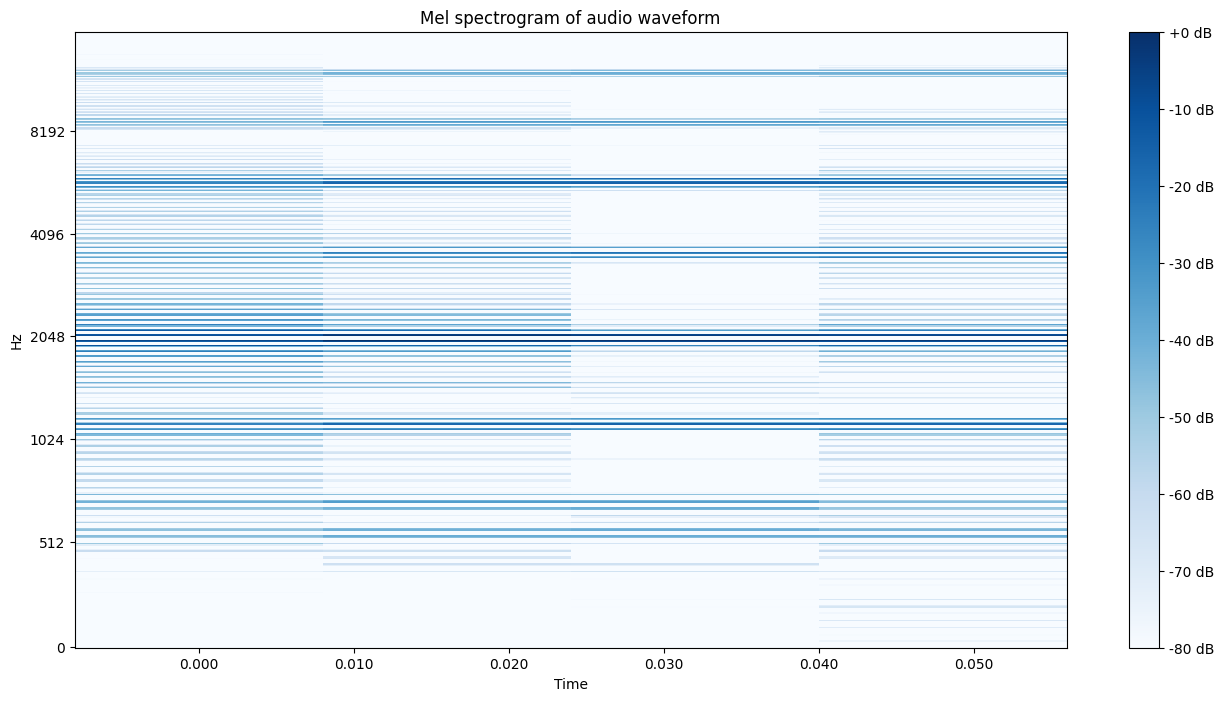

In [162]:
S = librosa.feature.melspectrogram(y=y[2053000:2055000], sr=sr, n_mels=128*4, fmax=2048)
S_Db_mel = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 8))
librosa.display.specshow(S_Db_mel, sr=sr, x_axis='time', y_axis='mel', cmap='Blues')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram of audio waveform')
plt.show()

spectral centroid of scan = [[2062.96831784 1870.33349867 1638.84029081 1449.91430096 1432.84288266
  1403.21637982 1337.10692237 1344.9075268  1388.14116615 1421.212275
  1433.80018969 1444.45745186 1475.5284903  1527.97838402 1600.55877324
  1586.10806269 1539.25793772 1535.46619441 1579.85344745 1617.77382063
  1558.38886731 1522.35890771 1523.61310335 1573.19702019 1653.46506088
  1643.81515651 1597.00445893 1557.2475583  1573.15217358 1618.38939013
  1598.47794601 1535.28859733 1486.068166   1472.82281639 1479.81332808
  1470.03407355 1443.88672975 1392.20718392 1388.91023798 1421.61442645
  1442.89801808 1430.63128003 1416.23647896 1406.83693069 1387.2300237
  1368.82851651 1365.7147256  1360.41227994 1356.36756454 1360.92072657
  1374.5369513  1385.85840679 1404.93452657 1442.05206901 1485.09718637
  1513.21007827 1526.87220738 1530.66161574 1541.33531987 1560.2244501
  1568.36155889 1566.30576363 1561.01176068 1574.26215243 1609.08576447
  1605.28938255 1550.43169625 1494.10558

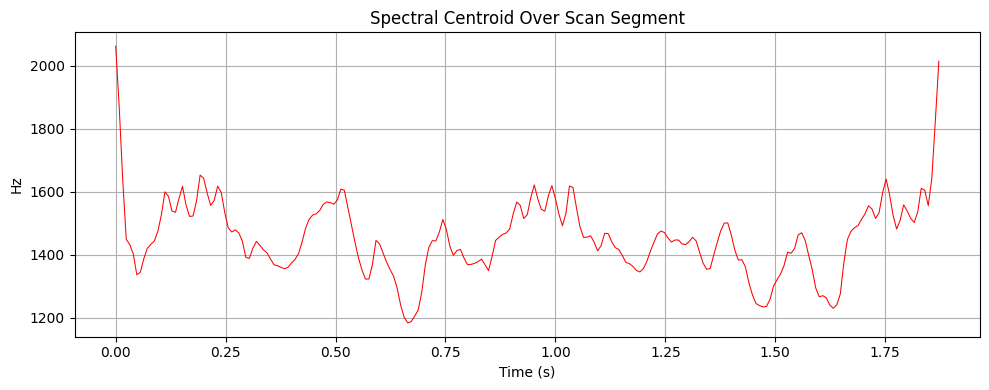

In [157]:
spect_centr_scan = librosa.feature.spectral_centroid(y=y[2040000:2100000], sr=sr, n_fft=2048, hop_length=256)
print(f'spectral centroid of scan = {spect_centr_scan}')
# 1D array
centroid_1d = spect_centr_scan[0]

# time axis
frames = range(len(centroid_1d))
t = librosa.frames_to_time(frames, sr=sr, hop_length=256)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, centroid_1d, label='Spectral Centroid', color='r', linewidth=0.75)
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.title('Spectral Centroid Over Scan Segment')
plt.grid(True)
plt.tight_layout()
plt.show()



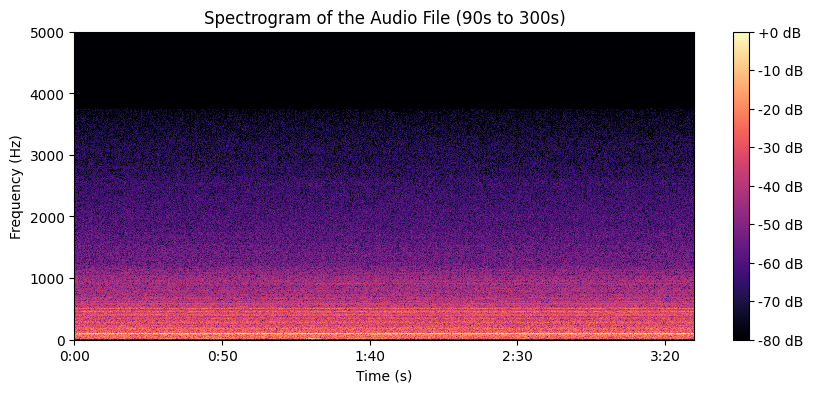

In [59]:
spectrogram = librosa.stft(y)
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the Audio File (90s to 300s)')
plt.xlabel('Time (s)')  
plt.ylabel('Frequency (Hz)')
plt.show()

In [ ]:
# Plot CWT
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coeffs), extent=[0, len(y)/sr, 1, 512],
           cmap='viridis', aspect='auto', vmax=np.percentile(np.abs(coeffs), 99))
plt.colorbar(label='Magnitude')
plt.yscale('log')
plt.title("CWT (Gaussian Wavelet) - 120s to 300s")
plt.xlabel("Time (s)")
plt.ylabel("Scale (log)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of the Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

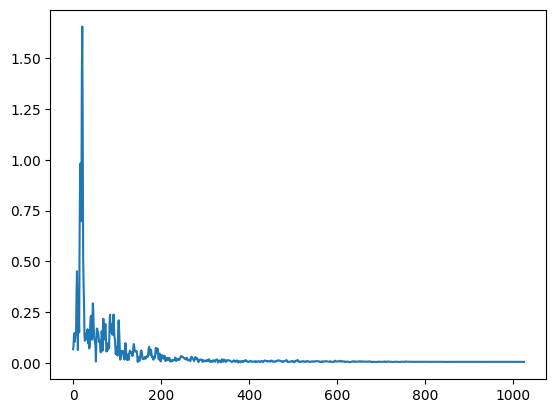

In [133]:
n_fft = 8000000  # Length of the FFT window
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1)) 
plt.plot(ft)

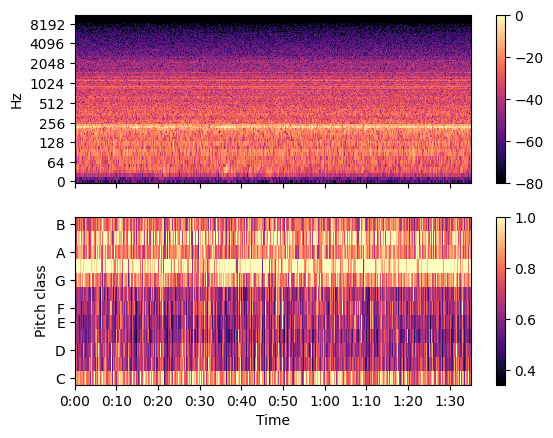

In [62]:
librosa.feature.chroma_stft(y=y, sr=sr)
S=np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])